# FSRCNN

In [1]:
import os, sys
from data import DatasetFromFolder, RGBDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from model import *
from torch.utils.tensorboard import SummaryWriter
from math import log10
from PIL import Image
import math

In [2]:
UPSCALE_FACTOR = 3  # 上采样系数
NUM_EPOCHS = 150      # the number of epochs

## dataset

In [3]:
current_path, filename = os.path.split('.')
current_path = current_path.replace('\\', '/')
image_dir = os.path.join(current_path, '../../data/')

generl100_dir = image_dir + '/General100/FSRCNN/X' + str(UPSCALE_FACTOR)
bsds200_val_dir = image_dir + '/BSDS200/X' + str(UPSCALE_FACTOR)
set5_test_dir = image_dir + '/Set5/X' + str(UPSCALE_FACTOR)
set14_test_dir = image_dir + '/Set14/X' + str(UPSCALE_FACTOR)

# ------------------- 数据集 --------------------------------------------
train_set = DatasetFromFolder(generl100_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())

val_set = DatasetFromFolder(bsds200_val_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
set5_test_set = DatasetFromFolder(set5_test_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
set14_test_set = DatasetFromFolder(set14_test_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
set5_test_loader = DataLoader(dataset=set5_test_set, batch_size=1, shuffle=False)
set14_test_loader = DataLoader(dataset=set14_test_set, batch_size=1, shuffle=False)
print(f'train_loader len: {len(train_loader)}')
print(f'val_loader len: {len(val_loader)}')
print(f'set5_test_loader len: {len(set5_test_loader)}')
print(f'set14_test_loader len: {len(set14_test_loader)}')

train_loader len: 617
val_loader len: 200
set5_test_loader len: 5
set14_test_loader len: 14


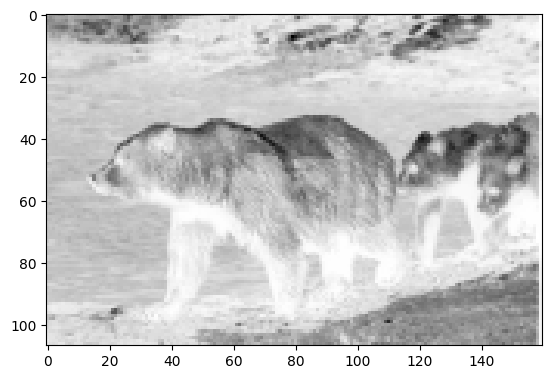

In [4]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    nping = img.numpy()
    if one_channel:
        plt.imshow(nping, cmap='Greys')
    else:
        plt.imshow(np.transpose(nping, (1, 2, 0)))
        
input, target = val_set[0]
matplotlib_imshow(input, one_channel=True)

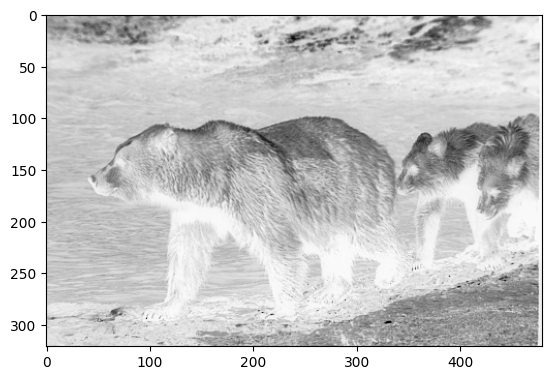

In [5]:
matplotlib_imshow(target, one_channel=True)

## model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)  # 设置PyTorch中所有随机数生成器的种子为0
torch.cuda.manual_seed(0) # 设置使用CUDA时的随机数生成器的种子为0

print(device)

cuda


In [7]:
loss_fn = nn.MSELoss()  # 损失函数

feature_dimension = [48, 56]   # LR特征维度
shrinking = [12, 16]           # 收缩程度
mapping_layers = [2, 3, 4]     # 映射层数

count_train_step = 0           # 训练次数
count_val_step = 0             # 验证次数
count_set5_step = 0            # set5数据集测试次数
count_set14_step = 0           # set14数据集测试次数

In [8]:
for feature in feature_dimension:
    for shrink in shrinking:
        for mapping in mapping_layers:
            train_step = 0           # 训练次数
            val_step = 0             # 验证次数
            set5_step = 0            # set5数据集测试次数
            set14_step = 0           # set14数据集测试次数
            
            detail = f'FSRCNN_{feature}_{shrink}_{mapping}_X{UPSCALE_FACTOR}_{NUM_EPOCHS}'
            # initialize network
            model = FSRCNN(UPSCALE_FACTOR, feature, shrink, mapping).to(device)
            # 优化器
            optimizer = optim.Adam([
                {'params': model.model_seq.parameters()},
                {'params': model.last_seq.parameters(), 'lr': 1e-4}
            ], lr = 1e-3)
            
            # writer into tensorboard
            writer = SummaryWriter(f'runs/FSRCNN/{detail}')
            # Visualize model in TensorBoard
            images, _ = next(iter(train_loader))
            writer.add_graph(model, images.to(device))
            writer.flush()
            
            # train, val and test
            for epoch in range(NUM_EPOCHS):
                losses = []
                model.train()
                for index, (X, y) in enumerate(train_loader):
                    # get data to cuda if possible
                    X = X.to(device)
                    y = y.to(device)
                    
                    # forward
                    y_pred = model(X)
                    loss = loss_fn(y_pred, y)
                    losses.append(loss.item())
                    
                    # backward
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    if train_step % 100 == 0:
                        writer.add_scalar('Training loss', sum(losses)/len(losses), global_step=train_step)
                    train_step += 1
                
                model.eval()
                losses = []
                psnrs = []
                with torch.no_grad():
                    for X, y in val_loader:
                        X = X.to(device)
                        y = y.to(device)
                        
                        y_pred = model(X)
                        loss = loss_fn(y_pred, y)
                        psnr = 10 * log10(1 / loss.item())
                        
                        losses.append(loss.item())
                        psnrs.append(psnr)
                        
                        if val_step % 100 == 0:
                            writer.add_scalar('Val loss',sum(losses)/len(losses), global_step=val_step)
                            writer.add_scalar('Val psnr',sum(psnrs)/len(psnrs), global_step=val_step)
                        val_step += 1
                
                losses = []
                psnrs = []
                # Set5 test
                with torch.no_grad():
                    for X, y in set5_test_loader:
                        X = X.to(device)
                        y = y.to(device)
                        
                        y_pred = model(X)
                        loss = loss_fn(y_pred, y)
                        psnr = 10 * log10(1/ loss.item())
                        losses.append(loss.item())
                        psnrs.append(psnr)
                    
                    writer.add_scalar('Set5 loss', sum(losses)/len(losses), global_step=set5_step)
                    writer.add_scalar('Set5 psnr', sum(psnrs)/len(psnrs), global_step=set5_step)
                    set5_step += 1
                    
                losses = []
                psnrs = []
                # Set14 test
                with torch.no_grad():
                    for X, y in set14_test_loader:
                        X = X.to(device)
                        y = y.to(device)
                        
                        y_pred = model(X)
                        loss = loss_fn(y_pred, y)
                        psnr = 10 * log10(1 / loss.item())
                        losses.append(loss.item())
                        psnrs.append(psnr)
                
                    writer.add_scalar('Set14 loss',sum(losses)/len(losses), 
                                    global_step=set14_step)
                    writer.add_scalar('Set14 psnr',sum(psnrs)/len(psnrs), 
                                    global_step=set14_step)
                    set14_step += 1
            
            torch.save(model, f'{detail}.pth')
            writer.flush()
                        
                        

## visualing results

target shape : torch.Size([1, 255, 255])


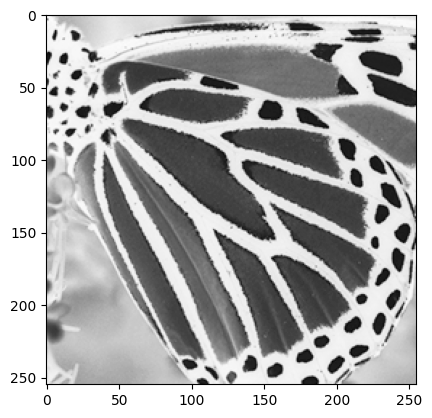

In [9]:
set5_rgb_test_set = RGBDataset(set5_test_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
set14_rgb_test_set = RGBDataset(set14_test_dir, upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())

set5_rgb_test_loader = DataLoader(dataset=set5_rgb_test_set, batch_size=1, shuffle=False)
set14_rgb_test_loader = DataLoader(dataset=set14_rgb_test_set, batch_size=1, shuffle=False)

img, target, _, _, _, _ = set5_rgb_test_set[2]
print(f'target shape : {target.shape}')
matplotlib_imshow(target, one_channel=True)

In [10]:
def ycbcr2rgb(tag, y, cb, cr):
    out_img_y = y.numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
    out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
    out_img.save(f'{tag}.jpg')

In [11]:
tag = 'FSRCNN_56_12_4_X3_150'

model = torch.load(f'{tag}.pth')
model = model.to(device)

writer = SummaryWriter(f'runs/FSRCNN/{tag}')

# Set5 test
fig = plt.figure(figsize=(12, 8))
count = 1
with torch.no_grad():
    for index, (X, y, in_cb, in_cr, ta_cb, ta_cr) in enumerate(set5_rgb_test_set):
    # for index, (X, y) in enumerate(set5_test_loader):
        ax = fig.add_subplot(5, 3, count, xticks=[], yticks=[])
        matplotlib_imshow(X, one_channel=True)
        ax.set_title('input')
        count += 1

        ax = fig.add_subplot(5, 3, count, xticks=[], yticks=[])
        matplotlib_imshow(y, one_channel=True)
        ax.set_title('target')
        count += 1

        X = X.unsqueeze(0)
        y = y.unsqueeze(0)
        
        X = X.to(device)
        y = y.to(device)
        
        y_pred = model(X)
        print(y_pred.shape)
        loss = loss_fn(y_pred, y)
        psnr = 10 * log10(1 / loss.item())
        
        ax = fig.add_subplot(5, 3, count, xticks=[], yticks=[])
        matplotlib_imshow(y_pred.cpu().squeeze(0), one_channel=True)
        ax.set_title(f'output loss:{loss.item() * 100:.2f}% psnr:{psnr:.2f}')
        count += 1
        
        X = X.to('cpu').squeeze(0)
        y = y.to('cpu').squeeze(0)
        y_pred = y_pred.to('cpu').squeeze(0)
        ycbcr2rgb(f'./Set5/{index}_input', X, in_cb, in_cr)
        ycbcr2rgb(f'./Set5/{index}_target', y, ta_cb, ta_cr)
        ycbcr2rgb(f'./Set5/{index}_output', y_pred, ta_cb, ta_cr)
        
writer.add_figure(f'{tag}_resluts', fig, global_step=0)
writer.flush()

torch.Size([1, 1, 510, 510])
torch.Size([1, 1, 288, 288])
torch.Size([1, 1, 255, 255])
torch.Size([1, 1, 279, 279])
torch.Size([1, 1, 342, 228])


## visualizing feature maps

In [12]:
model = model.to('cpu')
model_children = list(model.children())

model

FSRCNN(
  (model_seq): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=56)
    (2): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (3): PReLU(num_parameters=12)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=12)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=12)
    (8): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PReLU(num_parameters=12)
    (10): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): PReLU(num_parameters=12)
    (12): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (13): PReLU(num_parameters=56)
  )
  (last_seq): Sequential(
    (0): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(3, 3), padding=(4, 4), output_padding=(2, 2))
  )
)

In [25]:
set5_iter = iter(set5_test_loader)
# for n in range(0, 3):
#     img, target = next(set5_iter)
img, target = next(set5_iter)

results = []
for i in range(0, len(model_children)):
    # tmp = model_children[i](results[-1])
    if type(model_children[i]) == nn.Conv2d  \
            or type(model_children[i]) == nn.PixelShuffle \
            or type(model_children[i]) == nn.ConvTranspose2d :
        if not results:
            tmp = model_children[i](img)
        else:
            tmp = model_children[i](results[-1])
        results.append(tmp)
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            if type(model_children[i][j]) == nn.Conv2d  \
                    or type(model_children[i][j]) == nn.PixelShuffle \
                    or type(model_children[i][j]) == nn.ConvTranspose2d :
                if not results:
                    tmp = model_children[i][j](img)
                else:
                    tmp = model_children[i][j](results[-1])
                results.append(tmp)

outputs = results
print(len(outputs))

8


In [26]:
for num_layer in range(len(outputs)):
    print(f'each outputs shape: {outputs[num_layer].shape}')
    _, number, _, _ = tuple(outputs[num_layer].shape)
    number = int(math.ceil(math.sqrt(number)))
    
    fig = plt.figure()
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.detach()
    for i, filter in enumerate(layer_viz):
        plt.subplot(number, number, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis('off')
    # plt.show()
    writer.add_figure(f'{tag}_features_map_baby', fig, global_step=num_layer)
writer.flush()

each outputs shape: torch.Size([1, 56, 170, 170])
each outputs shape: torch.Size([1, 12, 170, 170])
each outputs shape: torch.Size([1, 12, 170, 170])
each outputs shape: torch.Size([1, 12, 170, 170])
each outputs shape: torch.Size([1, 12, 170, 170])
each outputs shape: torch.Size([1, 12, 170, 170])
each outputs shape: torch.Size([1, 56, 170, 170])
each outputs shape: torch.Size([1, 1, 510, 510])


## visualizing filters

In [21]:
model_weights = []

for i in range(0, len(model_children)):
    if type(model_children[i]) == nn.Conv2d \
            or type(model_children[i]) == nn.ConvTranspose2d:
        print(f'each filters weights: {model_children[i].weight.shape}')
        model_weights.append(model_children[i].weight)
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i].children():
            if type(child) == nn.Conv2d \
                    or type(child) == nn.ConvTranspose2d:
                print(f'each filters weights: {child.weight.shape}')
                model_weights.append(child.weight)

print(f'Total convolutional layers: {len(model_weights)}')

each filters weights: torch.Size([56, 1, 5, 5])
each filters weights: torch.Size([12, 56, 1, 1])
each filters weights: torch.Size([12, 12, 3, 3])
each filters weights: torch.Size([12, 12, 3, 3])
each filters weights: torch.Size([12, 12, 3, 3])
each filters weights: torch.Size([12, 12, 3, 3])
each filters weights: torch.Size([56, 12, 1, 1])
each filters weights: torch.Size([56, 1, 9, 9])
Total convolutional layers: 8


In [22]:
for i in range(0, len(model_weights)):
    fig = plt.figure(figsize=(50, 50))
    number, channel, _, _ = tuple(model_weights[i].shape)
    print(f'number: {number}  channel: {channel}')
    for index, filter in enumerate(model_weights[i]):
        # print(f'each filters weights: {filter.shape}')
        plt.subplot(8, 8, index + 1)
        plt.imshow(filter[0, :, :].detach(), cmap='gray')
        plt.axis('off')
        # print(filter[:, :, :].detach())
    # plt.show()
    writer.add_figure(f'{tag}_filters', fig, global_step=i)
writer.flush()

number: 56  channel: 1
number: 12  channel: 56
number: 12  channel: 12
number: 12  channel: 12
number: 12  channel: 12
number: 12  channel: 12
number: 56  channel: 12
number: 56  channel: 1
